In [1]:
# prints

#SELECTION

# print(f'rand:\n{self.pop[rand_cand_ids]}')
# print(f'randbest scores:\n{np.argmax(self.scores[rand_cand_ids],axis=1)}')

# print(f'best in rand: {self.pop[rand_cand_ids[np.arange(self.n_pop), np.argmax(self.scores[rand_cand_ids],axis=1)] ]}')
# print(f'best:\n{self.pop[best_cand_ids]}')
#print(self.pop[best_cand_ids].shape)
#parents = np.unique(self.pop[best_cand_ids], axis=0) # test part with unique
#print(len(best_cand_ids))
# print(f'pop:\n{self.pop}')
#print(f'parents:\n{parents}')
# print(f'unique parents:\n{np.unique(parents, axis=0)}')
# CROSSOVER

#print(np.random.rand(self.n-1) < self.crossover_prob)

# result_children = np.zeros((2*self.n, self.bits))    # 2* because we take each pair
# print(pairs_ids)
# print(valid_ids)
# print(pairs_ids[~valid_ids])
# print(type(pairs_ids[~valid_ids]))
# print(type(selected))
# print(change_ptr)
# print(selected)
#print(pairs_ids[valid_ids])

#print(selected[pairs_ids[valid_ids]])

# print(first)
# print(second)

In [3]:
import numpy as np
class GeneticAlgorithm(list):
    def __init__(self, n_pop=10, n_bits=10, select_k=3,
                 score_function=np.sum, crossover_prob=0.9, bounds=None,
                 n_epochs=5, mut_prob=None, minimize=False):
        super().__init__()
        self.n_pop = n_pop
        self.n_dim = len(bounds)
        self.n_bits = n_bits*len(bounds)  # multiplying because of groups
        self.pop = np.random.randint(0, 2, (n_pop, n_bits*len(bounds)))
        self.bounds = bounds  # for continuous function
        self.select_k = select_k

        self.mut_prob = mut_prob or 1.0 / n_bits   # mutation probability value is low typically
        self.crossover_prob = crossover_prob        # crossover probability value is high typically
        self.n_epochs = n_epochs
        self.minimize = minimize
        self.decoded = None
        self.score_function = score_function
        if score_function != np.sum:
            self.decoded = self.decode()
            self.scores = score_function(self.decoded)
        else:
            self.scores = score_function(self.pop, axis=1) # 2-d array
    def decode(self):
        """
            Taking a binary array of arrays (or bitstrings),
            function returns array of decoded to decimal numeric system array of arrays of numers.
            Vectorized.
            :return decoded: array of arrays with decimal numbers.
        """
        decoded = np.zeros((self.n_pop, self.n_dim))

        for group_num in np.arange(self.n_dim):
            begin, end = group_num*self.n_bits//self.n_dim, (group_num+1)*self.n_bits//self.n_dim
            temp_slice = self.pop[:, begin:end]

            temp_slice = temp_slice.dot(1 << np.arange(temp_slice.shape[-1] - 1, -1, -1))
            # putting values into an interval [a, b]
            # formulae is: a_i + k*(b_i - a_i)/2^n, where a, b -- borders, n -- number of bits
            denom = 2**(self.n_bits//self.n_dim)   # assuming n_bits for each group
            a, b = self.bounds[group_num]

            temp_slice = a + temp_slice*(b - a)/denom

            decoded[np.arange(self.n_pop), group_num] =  temp_slice
        return decoded

    def selection(self):
        """
        Searching for the best candidate for continuing population.
        Operation is vectorized.

        :return pop[best_cand_ids]: the best possible objects for continuing the population
        """
        best_cand_ids = np.random.randint(0, self.n_pop, self.n_pop)
        rand_cand_ids = np.random.randint(0, self.n_pop, (self.n_pop, self.select_k-1))

        if self.minimize:
            rand_cand_ids = rand_cand_ids[np.arange(self.n_pop), np.argmin(self.scores[rand_cand_ids],axis=1)] # for minimization
        else:
            rand_cand_ids = rand_cand_ids[np.arange(self.n_pop), np.argmax(self.scores[rand_cand_ids],axis=1)]  # watching at k random candidates

        # selecting only one for each gene

        mult = -1 if self.minimize else 1  # if we minimize the score function, simply multiply by 1
        ids_where_best_worse = mult*self.scores[rand_cand_ids] > mult*self.scores[best_cand_ids]
        best_cand_ids[ids_where_best_worse] = rand_cand_ids[ids_where_best_worse]


        parents = self.pop[best_cand_ids]
        # if len(parents) == 1:
        #     parents= np.vstack([parents, parents])

        return parents
    def mutation(self, children):
        """
            Performs mutation over children.
            Vectorized.
            Rewrites self.pop
            :param : current row to implement mutation
        """
        probs = np.random.rand(children.shape[0], self.n_bits)  # probs of mutations

        children[probs > self.mut_prob] = 1 - children[probs > self.mut_prob]

        return children

    def crossover(self, parents):
        pairs_ids = np.stack([np.arange(0, self.n_pop-1, 2), np.arange(1, self.n_pop, 2)], axis=1)  # just matrix (n-1, 2) with pairs of indexes: [[0, 1], [2, 3], [4, 5]...]

        probs_of_selection = np.random.rand(self.n_pop//2)  # probs of selection
        valid_pairs = pairs_ids[probs_of_selection <= self.crossover_prob]  # "<" because we're draw probability of "not to be crossovered"
        not_valid_pairs = pairs_ids[probs_of_selection > self.crossover_prob]
        change_ptr = np.random.randint(1, self.n_bits-2, valid_pairs.shape[0])

        children = parents[not_valid_pairs].tolist()

        for el_ind in np.arange(len(valid_pairs)): # no way of vectorization since pointers may vary

            first, second = parents[valid_pairs[el_ind]]
            res_first, res_second = first.copy(), second.copy()
            # changing substrings

            res_first[:change_ptr[el_ind]] = second[:change_ptr[el_ind]] # '+' operation works as an .append() function
            res_second[:change_ptr[el_ind]] = first[:change_ptr[el_ind]]

            #assert type(res_first) == np.ndarray
            children.append([res_first, res_second])
        children = np.vstack(children)

        return children
    def if_update_best(self, epoch):
        """
        Updates best value if have an update.
        Prints
        :param epoch: current epoch number

        """
        update_best = False
        if self.minimize:
            best_ind_temp = np.argmin(self.scores)
            if self.scores[best_ind_temp] < self.best_value:
                update_best = True
        else:
            best_ind_temp = np.argmax(self.scores)
            if self.scores[best_ind_temp] > self.best_value:
                update_best = True
        if update_best:
            best_ind = best_ind_temp.copy()
            best_val = self.scores[best_ind].copy()
            self.best_value = best_val
            print(f'Epoch {epoch}. The best element now is: {best_ind} with value: {best_val}.')
            print(f'Best element itself in binary code:\n{self.pop[best_ind]}\n and decode in decimal:'
                  f'\n{self.decoded[best_ind]}')
            print('-----------------------------------------------------------------------------------')

    def simulate(self):
        best_ind, best_val = 0, self.scores[0].copy()
        self.best_value = best_val
        for epoch in range(self.n_epochs):
            self.if_update_best(epoch)

            # main part of the algorithm
            parents = self.selection()
            children = self.crossover(parents)
            mutate = self.mutation(children)

            self.pop = mutate.copy()
            if self.score_function == np.sum:
                self.scores = self.score_function(self.pop, axis=1)
            else:
                self.decoded = self.decode()
                self.scores = self.score_function(self.decoded)


            if best_val == self.n_bits and self.score_function == np.sum:
                print(f'Found max with on {epoch} epoch')
                return

In [4]:
# 2 * x ** 2 + 14*y ** 3 -7*x*y + x - y**4
score_function = lambda x: 2*x[:, 0]**2 + 14*x[:, 1]**3 -7*x[:, 0]*x[:, 1] + x[:, 0] - x[:, 1]**4#+ x[:, 2]**4 #+ 4*x[:, 2]**3 # some continuous function to evaluate on. This case it's 3d function

himmelblau_function = lambda x: (x[:, 0]**2 + x[:, 1] - 11)**2 + (x[:, 0] + x[:, 1]**2 - 7)**2
bounds = [[-5, 5] for _ in range(2)] # bounds for obj function
n_bits_per_value = 16 # we need to specify bits for each value, i.e. in this case it will be 3*5
mut_prob = 1.0 / (len(bounds) * n_bits_per_value)
n_epochs = 100
# n different attempts
n_attempts = 4
decodes_4 = list()
scores_4 = list()
for i in range(n_attempts):
    # minimizing himmelblau_function
    gen_alg = GeneticAlgorithm(n_pop=100, n_bits=n_bits_per_value, bounds=bounds,
                               mut_prob=mut_prob, score_function=himmelblau_function, n_epochs=n_epochs, minimize=True)
    gen_alg.simulate()
    decodes_4.append(gen_alg.decoded)
    scores_4.append(gen_alg.scores)

Epoch 0. The best element now is: 38 with value: 7.529528492098461.
Best element itself in binary code:
[0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0]
 and decode in decimal:
[-2.35565186  2.89215088]
-----------------------------------------------------------------------------------
Epoch 1. The best element now is: 85 with value: 2.841774720619018.
Best element itself in binary code:
[1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1]
 and decode in decimal:
[ 3.35144043 -1.65817261]
-----------------------------------------------------------------------------------
Epoch 2. The best element now is: 95 with value: 1.4312860324429872.
Best element itself in binary code:
[1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0]
 and decode in decimal:
[3.05465698 1.65802002]
-----------------------------------------------------------------------------------
Epoch 3. The best element now is: 37 with value: 0.21384415333717785.
Best element itself

In [4]:
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import celluloid
from celluloid import Camera
import numpy as np

plt.rcParams['animation.convert_path'] = 'E:\ImageMagick-7.1.0-Q16-HDRI/magick.exe'

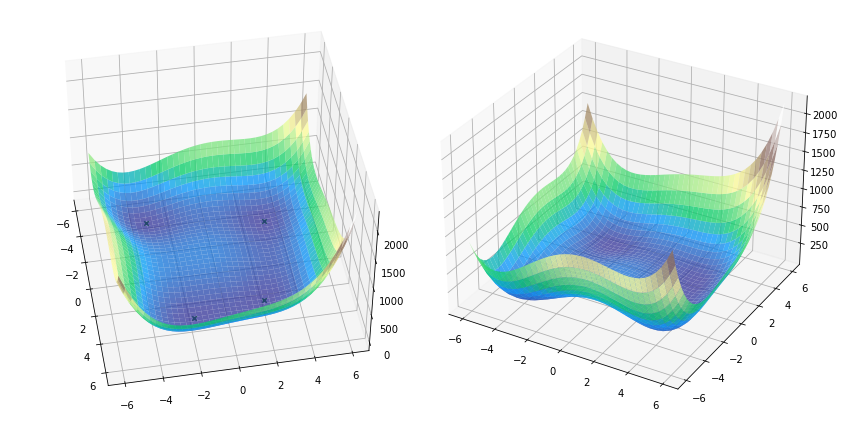

In [5]:
m1s = np.linspace(-6, 6, 40)
m2s = np.linspace(-6, 6, 40)
m1_mesh, m2_mesh = np.meshgrid(m1s, m2s) # create meshgrid
# def score_function(arr):
#     x, y = arr
#     return 2*x**2 + y**3
def himmelblau_function(arr):
    x, y = arr
    return (x**2 + y - 11)**2 + (x + y**2 -7)**2
zs = np.array([himmelblau_function(np.array([x_p, y_p])) for x_p, y_p in zip(np.ravel(m1_mesh), np.ravel(m2_mesh))])
z_mesh = zs.reshape(m1_mesh.shape)
fig = plt.figure(figsize=(27,7.5)) # create figure
ax0 = fig.add_subplot(111, projection='3d' )
ax0.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain', #surface plot
                 antialiased=True,cstride=1,rstride=1, alpha=0.75);
ax0.view_init(elev=45, azim=-10)
mins = [(3, 2), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126)]
for min in mins:
    x, y = min
    ax0.scatter(x, y, c='green', marker='x')
ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain', #surface plot
                 antialiased=True,cstride=1,rstride=1, alpha=0.75);

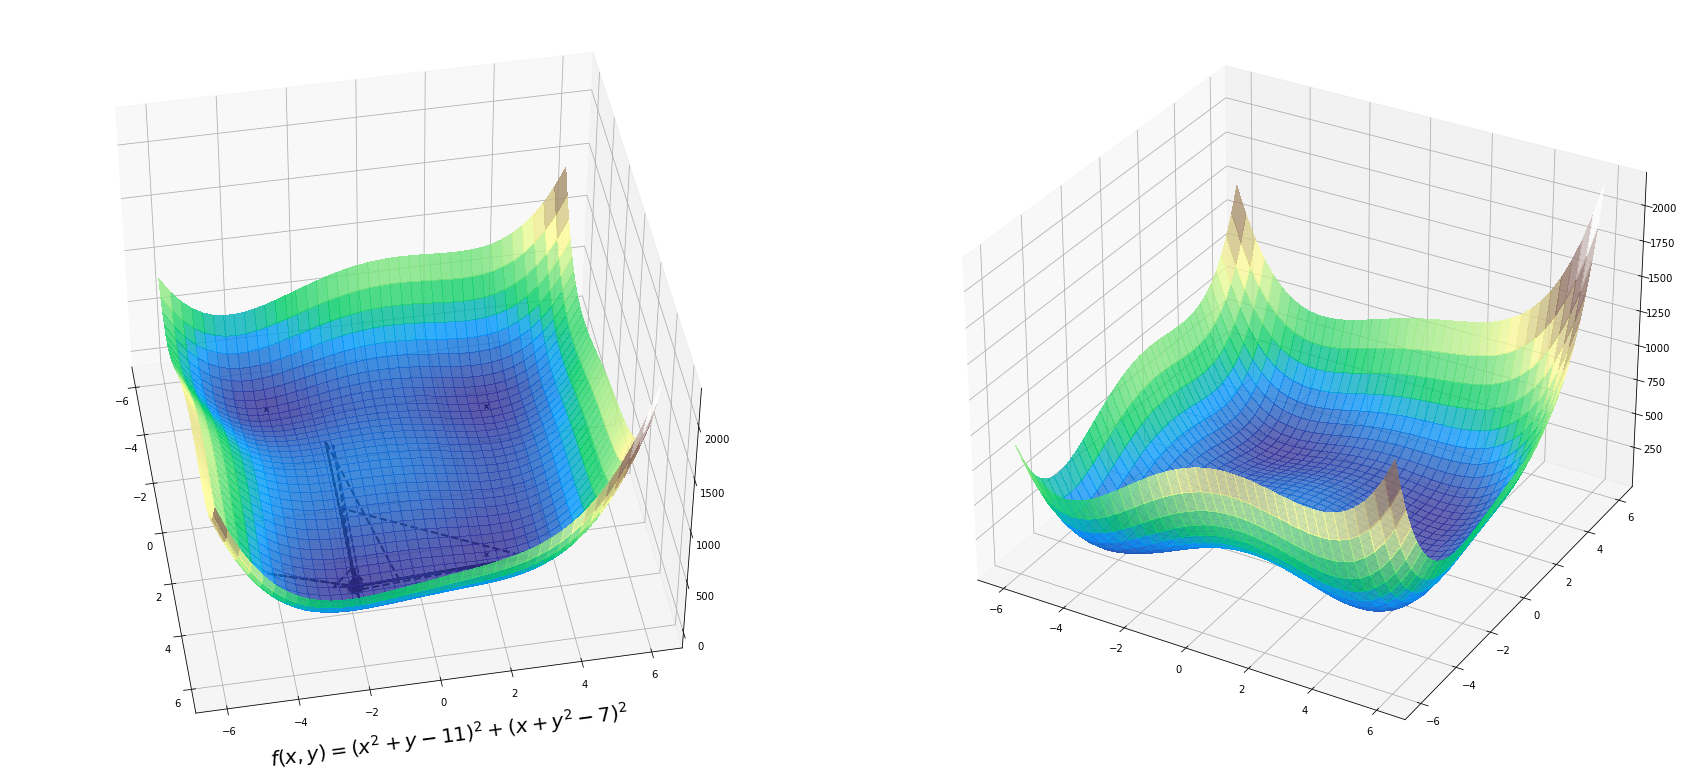

In [6]:
# def score_function(arr):
#     x, y = arr
#     return 2 * x ** 2 + 14*y ** 3 -7*x*y + x - y**4
from matplotlib import cm
m1s = np.linspace(-6, 6, 40)
m2s = np.linspace(-6, 6, 40)
m1_mesh, m2_mesh = np.meshgrid(m1s, m2s) # create meshgrid

zs = np.array([himmelblau_function(np.array([x_p, y_p])) for x_p, y_p in zip(np.ravel(m1_mesh), np.ravel(m2_mesh))])
z_mesh = zs.reshape(m1_mesh.shape)
decodes = gen_alg.decoded
scores = gen_alg.scores
p1=list(np.arange(0,n_epochs))
#p2=list(np.arange(200,9000,100))
points=p1#+p2
fig = plt.figure(figsize=(30, 18)) # create figure
ax = fig.add_subplot(121,projection='3d' )
ax1 = fig.add_subplot(122, projection='3d')
fontsize=20 # set axis label fontsize
labelsize=14 # set tick label fontsize
ax.set_ylabel(r'$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$', fontsize=fontsize, labelpad=15)

#ax.view_init(elev=30, azim=-10)
# ax.set_xlabel('x', fontsize=fontsize, labelpad=17)
# ax.set_ylabel('y', fontsize=fontsize, labelpad=5)
# ax.set_zlabel('z', fontsize=fontsize, labelpad=10)
# ax1.set_xlabel('x', fontsize=fontsize, labelpad=17)
# ax1.set_ylabel('y', fontsize=fontsize, labelpad=5)
# ax1.set_zlabel('z', fontsize=fontsize, labelpad=10)
# #ax.set_zlabel(r'$(x^2 + y - 11)^2 + (x + y^2 - 7)^2$', fontsize=fontsize, labelpad=-35)
# ax.tick_params(axis='x', pad=5, which='major', labelsize=labelsize)
# ax.tick_params(axis='y', pad=0, which='major', labelsize=labelsize)
# ax.tick_params(axis='z', pad=8, which='major', labelsize=labelsize)
# ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize)
# ax1.tick_params(axis='y', pad=0, which='major', labelsize=labelsize)
# ax1.tick_params(axis='z', pad=8, which='major', labelsize=labelsize)
#ax.set_zlim(-4, 1) # set range for z-values in the plot
i = 99
ax.plot(decodes[:i, 0],decodes[:i, 1],scores[:i],
        linestyle='dashed',linewidth=2,
        color="black", label=str(i));
ax.scatter(decodes[i, 0],decodes[i, 1],scores[i],
           marker='o', s=15**2,
           color="black", alpha=1.0);
# Surface plot (= loss landscape):
ax.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain',
                antialiased=False,alpha=0.8)#cstride=1,rstride=1, alpha=0.75);
ax.view_init(elev=45, azim=-10)
mins = [(3, 2), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126)]
for min in mins:
    x, y = min
    ax.scatter(x, y, c='black', marker='x')

ax1.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain', #surface plot
                 antialiased=False,cstride=1,rstride=1, alpha=0.75);

In [ ]:
%matplotlib inline
# def score_function(arr):
#     x, y = arr
#     return 2 * x ** 2 + 14*y ** 3 -7*x*y + x - y**4

fig = plt.figure(figsize=(30, 18)) # create figure
ax = fig.add_subplot(121,projection='3d' )
ax1 = fig.add_subplot(122, projection='3d')
line_style=["dashed", "dashdot", "dotted", "solid"] #linestyles
fontsize=20 # set axis label fontsize
labelsize=13 # set tick label fontsize
ax.view_init(elev=45, azim=-10)
ax.set_ylabel(r'$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$', fontsize=fontsize, labelpad=15)
#ax.set_zlim(-4, 1) # set range for z-values in the plot

m1s = np.linspace(-6, 6, 40)
m2s = np.linspace(-6, 6, 40)

m1_mesh, m2_mesh = np.meshgrid(m1s, m2s) # create meshgrid

zs = np.array([himmelblau_function(np.array([x_p, y_p])) for x_p, y_p in zip(np.ravel(m1_mesh), np.ravel(m2_mesh))])
z_mesh = zs.reshape(m1_mesh.shape)

# Define which epochs to plot:
# decodes = gen_alg.decoded
# scores = gen_alg.scores
p1=list(np.arange(0,n_epochs))
#p2=list(np.arange(200,9000,100))
points=p1#+p2

camera=Camera(fig) # create Camera object
for i in points:
    # Plot the three trajectories of genetic algorithm
    #each starting from its respective starting point
    #and each with a unique linestyle:
    for attempt in range(n_attempts):
        ax.plot(decodes_4[attempt][:i, 0],decodes_4[attempt][:i, 1],scores_4[attempt][:i],
                    linestyle=line_style[attempt],linewidth=2,
                    color="black", label=str(i));
        ax.scatter(decodes_4[attempt][i, 0],decodes_4[attempt][i, 1],scores_4[attempt][i],
                       marker='o', s=15**2,
                       color="black", alpha=1.0);
        ax1.plot(decodes_4[attempt][:i, 0],decodes_4[attempt][:i, 1],scores_4[attempt][:i],
                linestyle=line_style[attempt],linewidth=2,
                color="black", label=str(i));
        ax1.scatter(decodes_4[attempt][i, 0],decodes_4[attempt][i, 1],scores_4[attempt][i],
                   marker='o', s=15**2,
                   color="black", alpha=1.0);
    # Surface plot (= loss landscape):
    ax.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain',
                     antialiased=True,alpha=0.75); # cstride=1,rstride=1,
    mins = [(3, 2), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126)]
    for min in mins:
        x, y = min
        ax.scatter(x, y, c='black', marker='x')
    ax1.plot_surface(m1_mesh, m2_mesh, z_mesh, cmap='terrain', #surface plot
                     antialiased=True,cstride=1,rstride=1, alpha=0.75);
    ax.legend([f'epochs: {i}'], loc=(0.25, 0.8),fontsize=14) # set position of legend
    ax1.legend([f'epochs: {i}'], loc=(0.1, 0.5),fontsize=14)
    plt.tight_layout()
    camera.snap() # take snapshot after each iteration

ani = camera.animate(interval = 1e5, # set delay between frames in milliseconds
                             repeat = False,
                           repeat_delay = 0)
#animation.save('ga_1.gif', writer = 'imagemagick', dpi=100)  # save animation
writer = animation.ImageMagickWriter()
ani.save("genetic_algo_himmelblau_compressed.gif", writer=writer)

In [ ]:
-5 + (28125/65536) * (5 - -5)

In [ ]:
if __name__ == "__main__":
    # + 4*x[:, 2]**3 # some continuous function to evaluate on. This case it's 3d function
    score_function = lambda x: 2 * x[:, 0] ** 2 + \
                               x[:, 1] ** 3 + x[:, 2] ** 4
    bounds = [[-500, 500] for _ in range(3)]  # bounds for obj function
    n_bits_per_value = 16  # we need to specify bits for each value, i.e. in this case it will be 3*5
    mut_prob = 1.0 / (len(bounds) * n_bits_per_value)

    gen_alg = GeneticAlgorithm(n_pop=100, n_bits=n_bits_per_value, bounds=bounds,
                               mut_prob=mut_prob, score_function=score_function, n_epochs=100, minimize=False)
    gen_alg.simulate()